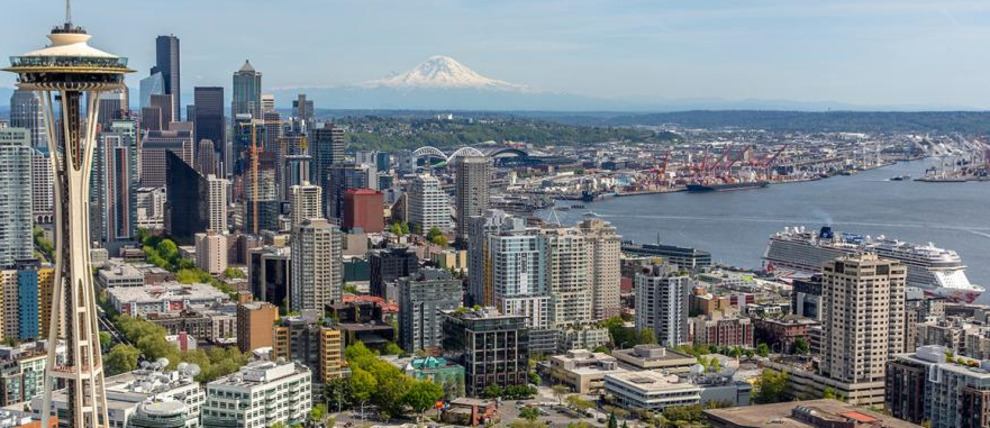

# KING COUNTY HOME PRICE PREDICTION

## Overview

For this project, we used multiple linear regression modeling to analyze house sales in King County, WA.

## Business Problem

A real estate agency wants us to model the sales price of homes in King County, Washington. They will use our model to help home buyers decide whether homes are underpriced or overpriced. The price of a home can be affected by multiple predictors. We will look at which predictors are statistically significant in terms of affecting a home price. Having a real estate agency use our model will build trust between them and the home buyer. This will likely result in the homebuyer using the same real estate agency if they sell their house in the future.


## Data Understanding

This data came from Kings County, Washington. It gives us the House Sales for homes in King County, Washington. There are 21,597 rows and 21 columns in the dataset. We will use this dataset to predict sales price for a potential home buyer. Each data entry represents a house, and includes its characteristics. Number of bedrooms, number of bathrooms, living area sq. ft., number of floors, zipcode are some of the columns in this dataset. Our target variable in this analysis is the price of the house. 

In our analysis, we iterated from simple linear model to multiple linear model by adding each mostly correlated column to the model and checking the multicollinearity at each iteration. 

We also created house_age and distance variables to use in our model.

House_age: Number of years since the house built, or since it is renovated. 

Distance: The mileage of the location of the house from the downtown Seattle. 


By the iteration process, we ended up using sqft_living, distance, grade_below_average, waterfront and view_YES columns as our predictors. 

In [1]:
 # Basic imports
import numpy as np
import pandas as pd
# Data visualizations
import matplotlib.pyplot as plt
import seaborn as sns
# Pre-Processing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.preprocessing import OneHotEncoder
# StatsModel and Metrics
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Install tool to get distance
from geopy import distance
# Map
import plotly.express as px
# To visualize the hidden columns in data
pd.options.display.max_columns=100 

#### Define Some Useful Functions

#### 1. Utility Function 

In [2]:
# # utils.py
# import matplotlib.pyplot as plt
# from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

def evaluate(y_train, train_preds, y_test, test_preds, log=False):
    '''
    Evaluate the amount of error between my model's predictionms and the actual values
    for both a train and a test set
    
    Inputs: 
        y_train - array like, actual values for 'price for my train dataset
        train_preds - array like, predicted values for 'price' for my train dataset
        y_test
        test_preds
    
    Outputs:
        None
    '''
    print(f"Train R2: {r2_score(y_train, train_preds):.4f}")
    print(f"Test R2: {r2_score(y_test, test_preds):.4f}")
    print("*****")
    if log == False:
        print(f"Train RMSE: ${mean_squared_error(y_train, train_preds, squared=False):,.2f}")
        print(f"Test RMSE: ${mean_squared_error(y_test, test_preds, squared=False):,.2f}")
        print("*****")
        print(f"Train MAE: ${mean_absolute_error(y_train, train_preds):,.2f}")
        print(f"Test MAE: ${mean_absolute_error(y_test, test_preds):,.2f}")
        print("*****")
    else:
        y_tr_unlog = np.exp(y_train)
        tr_pred_unlog=np.exp(train_preds)
        y_te_unlog=np.exp(y_test)
        te_pred_unlog=np.exp(test_preds)
        print(f"Train RMSE: ${mean_squared_error(y_tr_unlog, tr_pred_unlog, squared=False):,.2f}")
        print(f"Test RMSE: ${mean_squared_error(y_te_unlog, te_pred_unlog, squared=False):,.2f}")
        print("*****")
        print(f"Train MAE: ${mean_absolute_error(y_tr_unlog, tr_pred_unlog):,.2f}")
        print(f"Test MAE: ${mean_absolute_error(y_te_unlog, te_pred_unlog):,.2f}")
        print("*****")
    # Calculate our residuals 
    train_residuals = y_train - train_preds
    test_residuals = y_test - test_preds
    
    # Scatter plot 
    plt.scatter(train_preds, train_residuals, label = 'Train')
    plt.scatter(test_preds, test_residuals, label = 'Test')
    
    plt.axhline(y=0, color = 'red', label = '0')
    plt.xlabel('predictions')
    plt.ylabel('residuals')
    plt.legend()
    
    sm.qqplot(train_residuals, line = 'r', label = 'train residuals');
    plt.legend()
    
    sm.qqplot(test_residuals, line = 'r', label = 'test residuals');
    plt.legend()
    plt.show()  

#### 2. Iterative Feature Selection Function

In [3]:
def next_possible_feature(X_tr, X_te, y_tr, y_te, current_features, ignore_features=[]):
    '''
    This function will loop through each column that isn't in your feature model and 
    calculate the r-squared value if it were the next feature added to your model. It will
    display a dataframe with a sorted r-squared value based on the test dataset
    X_tr = X_train dataframe
    X_te = X_test dataframe
    y_tr = y_train dataframe
    y_te = y_test dataframe
    current_features = list of features that are already in your model
    ignore_features = list of features we know are multicollinear that we want to skip over
    '''
    function_dict = {'predictor': [], 'test r-squared':[]}
    for col in X_tr.columns:
        if col not in (current_features+ignore_features) and X_tr[col].dtypes in ['int64', 'float64']:
            function_X_tr = X_tr[current_features + [col]]
            function_X_te = X_te[current_features + [col]]
            function_model  = sm.OLS(y_tr, sm.add_constant(function_X_tr)).fit()
            function_train_preds = function_model.predict(sm.add_constant(function_X_tr))
            function_test_preds = function_model.predict(sm.add_constant(function_X_te))
            function_dict['predictor'].append(col)
            function_dict['test r-squared'].append(r2_score(y_te, function_test_preds))
    function_df = pd.DataFrame(function_dict).sort_values(by=['test r-squared'], ascending = False)
    display(function_df)

#### Read in Data

In [4]:
!ls data

column_names.md   kc_house_data.csv


In [5]:
# Load Housing Data Set
df = pd.read_csv('data/kc_house_data.csv')
df

id        date     price  bedrooms  bathrooms  sqft_living  \
0      7129300520  10/13/2014  221900.0         3       1.00         1180   
1      6414100192   12/9/2014  538000.0         3       2.25         2570   
2      5631500400   2/25/2015  180000.0         2       1.00          770   
3      2487200875   12/9/2014  604000.0         4       3.00         1960   
4      1954400510   2/18/2015  510000.0         3       2.00         1680   
...           ...         ...       ...       ...        ...          ...   
21592   263000018   5/21/2014  360000.0         3       2.50         1530   
21593  6600060120   2/23/2015  400000.0         4       2.50         2310   
21594  1523300141   6/23/2014  402101.0         2       0.75         1020   
21595   291310100   1/16/2015  400000.0         3       2.50         1600   
21596  1523300157  10/15/2014  325000.0         2       0.75         1020   

       sqft_lot  floors waterfront  view  condition          grade  \
0          5650     1.0        NaN  NONE    Average      7 Average   
1          7242     2.0         NO  NONE    Average      7 Average   
2         10000     1.0         NO  NONE    Average  6 Low Average   
3          5000     1.0         NO  NONE  Very Good      7 Average   
4          8080     1.0         NO  NONE    Average         8 Good   
...         ...     ...        ...   ...        ...            ...   
21592      1131     3.0         NO  NONE    Average         8 Good   
21593      5813     2.0         NO  NONE    Average         8 Good   
21594      1350     2.0         NO  NONE    Average      7 Average   
21595      2388     2.0        NaN  NONE    Average         8 Good   
21596      1076     2.0         NO  NONE    Average      7 Average   

       sqft_above sqft_basement  yr_built  yr_renovated  zipcode      lat  \
0            1180           0.0      1955           0.0    98178  47.5112   
1            2170         400.0      1951        1991.0    98125  47.7210   
2             770           0.0      1933           NaN    98028  47.7379   
3            1050         910.0      1965           0.0    98136  47.5208   
4            1680           0.0      1987           0.0    98074  47.6168   
...           ...           ...       ...           ...      ...      ...   
21592        1530           0.0      2009           0.0    98103  47.6993   
21593        2310           0.0      2014           0.0    98146  47.5107   
21594        1020           0.0      2009           0.0    98144  47.5944   
21595        1600           0.0      2004           0.0    98027  47.5345   
21596        1020           0.0      2008           0.0    98144  47.5941   

          long  sqft_living15  sqft_lot15  
0     -122.257           1340        5650  
1     -122.319           1690        7639  
2     -122.233           2720        8062  
3     -122.393           1360        5000  
4     -122.045           1800        7503  
...        ...            ...         ...  
21592 -122.346           1530        1509  
21593 -122.362           1830        7200  
21594 -122.299           1020        2007  
21595 -122.069           1410        1287  
21596 -122.299           1020        1357  

[21597 rows x 21 columns]

In [6]:
#Information on dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [7]:
#Describe the dataframe with descriptive statistics
df.describe()

id         price      bedrooms     bathrooms   sqft_living  \
count  2.159700e+04  2.159700e+04  21597.000000  21597.000000  21597.000000   
mean   4.580474e+09  5.402966e+05      3.373200      2.115826   2080.321850   
std    2.876736e+09  3.673681e+05      0.926299      0.768984    918.106125   
min    1.000102e+06  7.800000e+04      1.000000      0.500000    370.000000   
25%    2.123049e+09  3.220000e+05      3.000000      1.750000   1430.000000   
50%    3.904930e+09  4.500000e+05      3.000000      2.250000   1910.000000   
75%    7.308900e+09  6.450000e+05      4.000000      2.500000   2550.000000   
max    9.900000e+09  7.700000e+06     33.000000      8.000000  13540.000000   

           sqft_lot        floors    sqft_above      yr_built  yr_renovated  \
count  2.159700e+04  21597.000000  21597.000000  21597.000000  17755.000000   
mean   1.509941e+04      1.494096   1788.596842   1970.999676     83.636778   
std    4.141264e+04      0.539683    827.759761     29.375234    399.946414   
min    5.200000e+02      1.000000    370.000000   1900.000000      0.000000   
25%    5.040000e+03      1.000000   1190.000000   1951.000000      0.000000   
50%    7.618000e+03      1.500000   1560.000000   1975.000000      0.000000   
75%    1.068500e+04      2.000000   2210.000000   1997.000000      0.000000   
max    1.651359e+06      3.500000   9410.000000   2015.000000   2015.000000   

            zipcode           lat          long  sqft_living15     sqft_lot15  
count  21597.000000  21597.000000  21597.000000   21597.000000   21597.000000  
mean   98077.951845     47.560093   -122.213982    1986.620318   12758.283512  
std       53.513072      0.138552      0.140724     685.230472   27274.441950  
min    98001.000000     47.155900   -122.519000     399.000000     651.000000  
25%    98033.000000     47.471100   -122.328000    1490.000000    5100.000000  
50%    98065.000000     47.571800   -122.231000    1840.000000    7620.000000  
75%    98118.000000     47.678000   -122.125000    2360.000000   10083.000000  
max    98199.000000     47.777600   -121.315000    6210.000000  871200.000000

We looked into each column values by using *df['column_name'].value_counts()* code to see the details. For more details, please see the **TeamBrass.ipynb** jupyter notebook.

## Data Preparation

After looking into value counts of the each column, we decided to 

- replace 33 bedroom house with 3 bedroom, which is the mean of the bedrooms in our dataset.
- replace '?' in the sqft_basement by subtracting thft_above from sqft_living.
- create binary variable of waterfront by assigning from YES/NO to 1/0.
- change the null entries for yr_renovated to 0
- create a new column that with any house that has a view as 1, and no view is 0.
- create 'distance' by using 'long' and 'lat' columns.
- filter out houses located more than 25 miles away from the Downtown.
- create 'house_age' column, number of years the house is renovated, if not years it is built .
- engineer columns of object type (i.e. 'view', 'condition', 'grade') into numerical columns using one hot encoder.
- filter out houses with more than 4000 sq. ft. livin area space.

In [8]:
#Replace 33 bedrooms with 3 bedrooms, since 3 is the mean for bedroom count in this dataset
#We suspect this was a typing error when entering the home data
#We did this first because we say the outlier from df.describe()
df['bedrooms'].replace(33, 3, inplace=True)

In [9]:
#Change ? entries for sqft_basement
#This is done by subtracting the sqft_above from sqft_living
df['sqft_basement_diff']= df['sqft_living'] - df['sqft_above']
df.drop('sqft_basement', axis = 1, inplace = True)

#### Check null values in the dataframe

In [10]:
df.isna().sum()

id                       0
date                     0
price                    0
bedrooms                 0
bathrooms                0
sqft_living              0
sqft_lot                 0
floors                   0
waterfront            2376
view                    63
condition                0
grade                    0
sqft_above               0
yr_built                 0
yr_renovated          3842
zipcode                  0
lat                      0
long                     0
sqft_living15            0
sqft_lot15               0
sqft_basement_diff       0
dtype: int64

In [11]:
#Change the entries in waterfront from YES/NO to 1/0
#We filled the nulls with 0 because the mode is 0 by a substantial amount
df['waterfront'].replace("YES", 1, inplace=True)
df['waterfront'].replace("NO", 0, inplace=True)
df['waterfront'].fillna(value=0,inplace=True)

In [12]:
#Change the null entries for yr_renovated to 0
#We suspected there are null values in this column if the house wasn't ever renovated
df['yr_renovated'].fillna(value=0,inplace=True)

In [13]:
#Change the null values for view to NONE
df['view'].fillna(value='NONE',inplace=True)

In [14]:
#Create a column that with any house that has a view, no matter how well it is
df['view_YES'] = df['view']
df['view_YES'].replace('NONE', 0, inplace=True)
df['view_YES'].replace(['AVERAGE','GOOD','FAIR', 'EXCELLENT'], 1, inplace = True)
df['view_YES'].value_counts()

0    19485
1     2112
Name: view_YES, dtype: int64

In [15]:
#Add a column that calculates the distance from the downtown
distance_data = []
for i in df.index:
    location = (df.loc[i]['lat'],df.loc[i]['long'])
    downtown = (47.6050, -122.3344)
    dist = distance.distance(location, downtown).miles
    distance_data.append(dist)
df['distance'] = distance_data

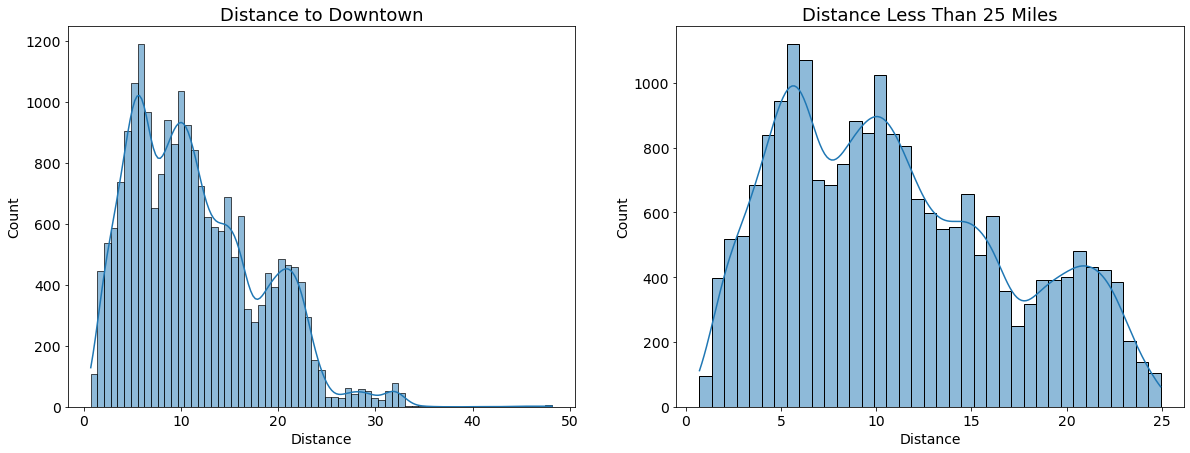

In [16]:
#Visualization of the Distance column
plt.figure(figsize=(20,7))

plt.subplot(1,2,1)
plt.title('Distance to Downtown', fontsize=18)
sns.histplot(df['distance'], kde=True)
plt.xlabel("Distance", fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.subplot(1,2,2)
plt.title('Distance Less Than 25 Miles', fontsize=18)
sns.histplot(df[df['distance']<25]['distance'], kde=True)
plt.xlabel("Distance",fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()

We filtered our data by 25 miles radius distance from the downtown. After this filtering we still have 97% of the original dataset in our model.

In [17]:
ratio_within_25_miles = len(df[df['distance']<25])/len(df['distance'])
ratio_within_25_miles
#97.5 percent of the houses are still being used.

0.9748113163865352

In [18]:
# Explore relationship between location and distance
fig = px.scatter_mapbox(data_frame = df, # df name
                        lat='lat', # name of latitude column
                        lon='long', # name of longitude column
                        color='distance', # name of column to use for the color
                        zoom=8)

fig.update_layout(mapbox_style="open-street-map")

In [19]:
#Filter dataset by only including houses within 25 miles
df = df[df['distance']<25]

In [20]:
#create new 'house_age' column:
age_data = []
for i in df.index:
    if df.loc[i]['yr_renovated']==0.0:
        age = 2016 - df.loc[i]['yr_built']  
    else:
        age = 2016 - df.loc[i]['yr_renovated']
    age_data.append(age)
df['house_age'] = age_data

<ipython-input-20-a5d74d2b02fc>:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [21]:
df.isna().sum()

id                    0
date                  0
price                 0
bedrooms              0
bathrooms             0
sqft_living           0
sqft_lot              0
floors                0
waterfront            0
view                  0
condition             0
grade                 0
sqft_above            0
yr_built              0
yr_renovated          0
zipcode               0
lat                   0
long                  0
sqft_living15         0
sqft_lot15            0
sqft_basement_diff    0
view_YES              0
distance              0
house_age             0
dtype: int64

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21053 entries, 0 to 21596
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  21053 non-null  int64  
 1   date                21053 non-null  object 
 2   price               21053 non-null  float64
 3   bedrooms            21053 non-null  int64  
 4   bathrooms           21053 non-null  float64
 5   sqft_living         21053 non-null  int64  
 6   sqft_lot            21053 non-null  int64  
 7   floors              21053 non-null  float64
 8   waterfront          21053 non-null  float64
 9   view                21053 non-null  object 
 10  condition           21053 non-null  object 
 11  grade               21053 non-null  object 
 12  sqft_above          21053 non-null  int64  
 13  yr_built            21053 non-null  int64  
 14  yr_renovated        21053 non-null  float64
 15  zipcode             21053 non-null  int64  
 16  lat 

In [23]:
df.select_dtypes(include = "object")

date  view  condition          grade
0      10/13/2014  NONE    Average      7 Average
1       12/9/2014  NONE    Average      7 Average
2       2/25/2015  NONE    Average  6 Low Average
3       12/9/2014  NONE  Very Good      7 Average
4       2/18/2015  NONE    Average         8 Good
...           ...   ...        ...            ...
21592   5/21/2014  NONE    Average         8 Good
21593   2/23/2015  NONE    Average         8 Good
21594   6/23/2014  NONE    Average      7 Average
21595   1/16/2015  NONE    Average         8 Good
21596  10/15/2014  NONE    Average      7 Average

[21053 rows x 4 columns]

In [24]:
obj_column = [c for c in df.columns if df[c].dtype == 'object']
df[obj_column].describe()

date   view condition      grade
count       21053  21053     21053      21053
unique        372      5         5         10
top     6/23/2014   NONE   Average  7 Average
freq          140  19040     13680       8720

In [25]:
df['grade_int'] = df['grade'].str[:2].astype(int)

<ipython-input-25-53390a5acd50>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [26]:
df['grade_below_average'] = df['grade_int']
df['grade_below_average'].replace([4,5,6,7], 1, inplace=True)
df['grade_below_average'].replace([8,9,10,11, 12, 13], 0, inplace=True)
df['grade_below_average'].value_counts()

<ipython-input-26-d3d4ce825dda>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/garrettwilliams/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/series.py:4563: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



1    10935
0    10118
Name: grade_below_average, dtype: int64

In [27]:
df['grade_above_average'] = df['grade_int']
df['grade_above_average'].replace([10,11,12,13], 1, inplace=True)
df['grade_above_average'].replace([8,9,4,5, 6, 7], 0, inplace=True)
df['grade_above_average'].value_counts()

<ipython-input-27-b4dba7dc4c05>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



0    19435
1     1618
Name: grade_above_average, dtype: int64

In [28]:
df['grade_is_average'] = df['grade_int']
df['grade_is_average'].replace([8,9], 1, inplace=True)
df['grade_is_average'].replace([4,5,6,7,10,11,12,13], 0, inplace=True)
df['grade_is_average'].value_counts()

<ipython-input-28-6e986c52f086>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



0    12553
1     8500
Name: grade_is_average, dtype: int64

In [29]:
df.drop("grade", axis=1, inplace=True)
df.drop('grade_int', axis=1, inplace=True)

/Users/garrettwilliams/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [30]:
# Create a variable for 'view' and 'condition' columns
view_col = df[["view"]]
condition_df = df[["condition"]]

# Instantiate a OneHotEncoder with categories="auto",
# sparse=False, and handle_unknown="ignore"
ohe_view = OneHotEncoder(categories="auto",sparse=False, handle_unknown="ignore")
ohe_cond = OneHotEncoder(categories="auto", sparse=False, handle_unknown="ignore")

# Fit the encoder on view_col and condition_df
ohe_view.fit(view_col)
ohe_cond.fit(condition_df)

OneHotEncoder(handle_unknown='ignore', sparse=False)

In [31]:
# Transform view_col and condition_df using the encoder
view_col_encoded = ohe_view.transform(view_col)
condition_df_encoded = ohe_cond.transform(condition_df)

In [32]:
# Make the transformed data into a dataframe
view_col_encoded = pd.DataFrame(
    # Pass in NumPy array
    view_col_encoded,
    # Set the column names to the categories found by OHE
    columns="view_"+ohe_view.categories_[0],
    # Set the index to match df's index
    index=df.index
)
condition_df_encoded = pd.DataFrame(
    # Pass in NumPy array
    condition_df_encoded,
    # Set the column names to the categories found by OHE
    columns="cond_"+ohe_cond.categories_[0],
    # Set the index to match df's index
    index=df.index
)

In [33]:
# Drop original view & condition columns
df.drop("view", axis=1, inplace=True)
df.drop("condition", axis=1, inplace=True)

# Concatenate the new dataframe with current df
df = pd.concat([df, view_col_encoded, condition_df_encoded], axis=1)

df.head()

/Users/garrettwilliams/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



id        date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520  10/13/2014  221900.0         3       1.00         1180   
1  6414100192   12/9/2014  538000.0         3       2.25         2570   
2  5631500400   2/25/2015  180000.0         2       1.00          770   
3  2487200875   12/9/2014  604000.0         4       3.00         1960   
4  1954400510   2/18/2015  510000.0         3       2.00         1680   

   sqft_lot  floors  waterfront  sqft_above  yr_built  yr_renovated  zipcode  \
0      5650     1.0         0.0        1180      1955           0.0    98178   
1      7242     2.0         0.0        2170      1951        1991.0    98125   
2     10000     1.0         0.0         770      1933           0.0    98028   
3      5000     1.0         0.0        1050      1965           0.0    98136   
4      8080     1.0         0.0        1680      1987           0.0    98074   

       lat     long  sqft_living15  sqft_lot15  sqft_basement_diff  view_YES  \
0  47.5112 -122.257           1340        5650                   0         0   
1  47.7210 -122.319           1690        7639                 400         0   
2  47.7379 -122.233           2720        8062                   0         0   
3  47.5208 -122.393           1360        5000                 910         0   
4  47.6168 -122.045           1800        7503                   0         0   

    distance  house_age  grade_below_average  grade_above_average  \
0   7.422544       61.0                    1                    0   
1   8.046186       25.0                    1                    0   
2  10.329114       83.0                    1                    0   
3   6.430056       51.0                    1                    0   
4  13.544634       29.0                    0                    0   

   grade_is_average  view_AVERAGE  view_EXCELLENT  view_FAIR  view_GOOD  \
0                 0           0.0             0.0        0.0        0.0   
1                 0           0.0             0.0        0.0        0.0   
2                 0           0.0             0.0        0.0        0.0   
3                 0           0.0             0.0        0.0        0.0   
4                 1           0.0             0.0        0.0        0.0   

   view_NONE  cond_Average  cond_Fair  cond_Good  cond_Poor  cond_Very Good  
0        1.0           1.0        0.0        0.0        0.0             0.0  
1        1.0           1.0        0.0        0.0        0.0             0.0  
2        1.0           1.0        0.0        0.0        0.0             0.0  
3        1.0           0.0        0.0        0.0        0.0             1.0  
4        1.0           1.0        0.0        0.0        0.0             0.0

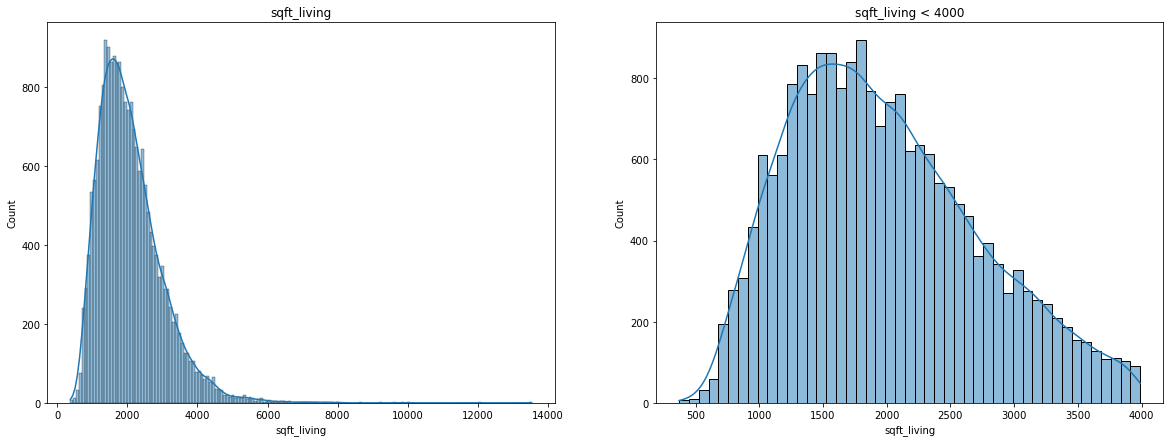

In [34]:
plt.figure(figsize=(20,7))

plt.subplot(1,2,1)
plt.title('sqft_living')
sns.histplot(df['sqft_living'], kde=True)

plt.subplot(1,2,2)
plt.title('sqft_living < 4000')
sns.histplot(df[df['sqft_living']<4000]['sqft_living'], kde=True)

plt.show()

In [35]:
#We transformed the sqft_living column because it is heavily skewed
df = df[df['sqft_living']<4000]

We filtered sqft living to only less than 4000 so that it isn't as heavily skewed.

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20279 entries, 0 to 21596
Data columns (total 34 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   20279 non-null  int64  
 1   date                 20279 non-null  object 
 2   price                20279 non-null  float64
 3   bedrooms             20279 non-null  int64  
 4   bathrooms            20279 non-null  float64
 5   sqft_living          20279 non-null  int64  
 6   sqft_lot             20279 non-null  int64  
 7   floors               20279 non-null  float64
 8   waterfront           20279 non-null  float64
 9   sqft_above           20279 non-null  int64  
 10  yr_built             20279 non-null  int64  
 11  yr_renovated         20279 non-null  float64
 12  zipcode              20279 non-null  int64  
 13  lat                  20279 non-null  float64
 14  long                 20279 non-null  float64
 15  sqft_living15        20279 non-null 

#### After all these filterings, we have 20,279 data in our final dataset!

## Modeling

We will use linear regression model for our prediction problem. We will start with baseline model, using only average house prices for our prediction, then we will use simple linear regression model by choosing the mostly correlated column with our target variable as our predictor. After deciding the simple linear regression model, we will use *next_possible_feature()* function defined above to choose our next predictors. At each iteration step, we will calculate vif score to make sure we are not having multicollinearity isuue.

We split our dataframe into train and test set, to calculate our residuals and see that our model can predict the new data as well as the trained data.


In [37]:
X = df.drop(columns=['id', 'price'])
y = df['price']

In [38]:
# Train - Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [39]:
train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

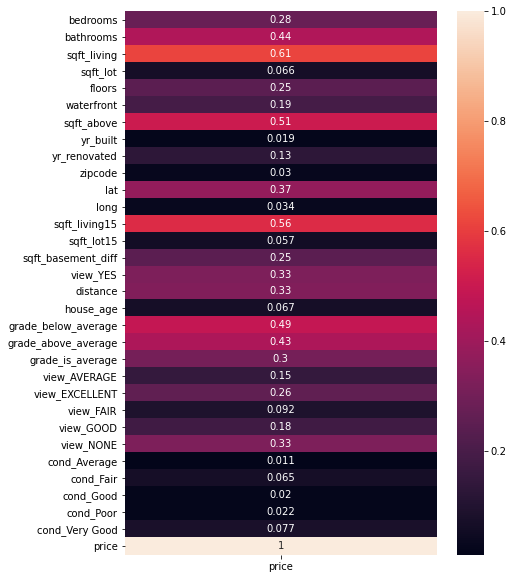

In [40]:
# Absolute value correlations with price
plt.figure(figsize=(7,10))
sns.heatmap(abs(train_df.corr())[['price']], annot=True);

In [41]:
np.abs(train_df.corr()['price']).sort_values(ascending = False)

price                  1.000000
sqft_living            0.614300
sqft_living15          0.555927
sqft_above             0.507937
grade_below_average    0.489868
bathrooms              0.443030
grade_above_average    0.433065
lat                    0.374644
distance               0.332264
view_YES               0.326944
view_NONE              0.326944
grade_is_average       0.304569
bedrooms               0.277219
view_EXCELLENT         0.255868
floors                 0.245709
sqft_basement_diff     0.245517
waterfront             0.191981
view_GOOD              0.178990
view_AVERAGE           0.147472
yr_renovated           0.128024
view_FAIR              0.091633
cond_Very Good         0.077206
house_age              0.066643
sqft_lot               0.065506
cond_Fair              0.065382
sqft_lot15             0.057320
long                   0.033599
zipcode                0.029504
cond_Poor              0.021884
cond_Good              0.020244
yr_built               0.018826
cond_Ave

## Evaluation

We started with a baseline understanding. This baseline model only looked at the mean of y_train. We knew this was going to be a bad model and the R-squared value being 0.0 proved it.

Next, for our first simple linear regression model, we only used the sq_ft_living as the predictor because it had the highest correlation to price. R-squared was 0.37 which isn't good enough. So we decided to add more predictors and make a multiple linear regression model. When we made the model, we saw that the distribution of the price was skewed. So we log transformed our target value to help improve the model.

To decide what predictors to add, we wrote a function that would iterate through all possible features and calculate the test r-squared value if the feature was added. After we picked the top feature, we checked if it was multicollinear by calculating the VIF score. If it was, we would look at adding feature that resulted in the next best r-squared value. We would then create a model with those predictors and compared it's r-squared value and RMSE with the previous model. We would also check the features p-value using the summary() function to make sure those features are statistically significant.

We continued to follow this process until we got our final 5 predictors, and we made sure to unlog our target value to get a realistic RMSE. Our final model predicts 65% of the variance. The r-squared value is 0.65 and our RMSE was very close to $160,000 for both our train and test set. 

### Baseline Understanding

- In the baseline model, we will only use average house prices for our prediction, and calculate the residuals accordingly. We will look R-squared values, RMSE, and MAE of both train and test sets.

In [42]:
# code here to arrive at a baseline prediction
train_target_mean = y_train.mean()
train_target_mean

506389.9129462818

Train R2: 0.0000
Test R2: -0.0001
*****
Train RMSE: $274,383.60
Test RMSE: $271,772.12
*****
Train MAE: $198,035.46
Test MAE: $194,483.02
*****


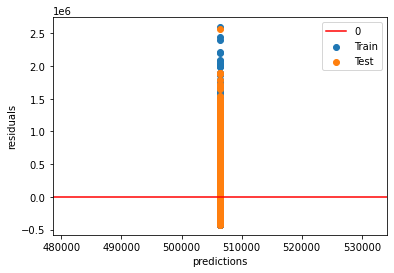

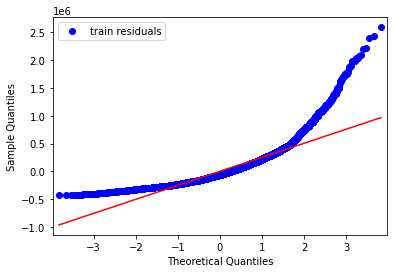

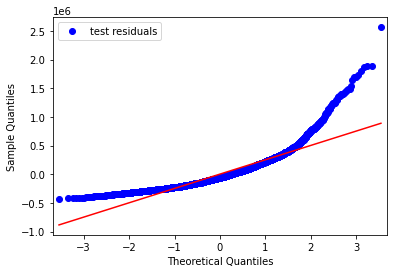

In [43]:
baseline_train_preds = [train_target_mean]*len(y_train)
baseline_test_preds = [train_target_mean]*len(y_test)
evaluate(y_train, baseline_train_preds, y_test, baseline_test_preds)

It is seen from the residuls plot, and qq-plots that the baseline model poorly predicts the house prices.

### First Simple Model

We will look at the correlation matrix to choose our first predictor, whic correlates with the price column the most! 

We decided to use 'sqft_living' column as our first predictor, and used simple linear regression for the analysis. 

In [44]:
np.abs(train_df.corr()['price']).sort_values(ascending = False)

price                  1.000000
sqft_living            0.614300
sqft_living15          0.555927
sqft_above             0.507937
grade_below_average    0.489868
bathrooms              0.443030
grade_above_average    0.433065
lat                    0.374644
distance               0.332264
view_YES               0.326944
view_NONE              0.326944
grade_is_average       0.304569
bedrooms               0.277219
view_EXCELLENT         0.255868
floors                 0.245709
sqft_basement_diff     0.245517
waterfront             0.191981
view_GOOD              0.178990
view_AVERAGE           0.147472
yr_renovated           0.128024
view_FAIR              0.091633
cond_Very Good         0.077206
house_age              0.066643
sqft_lot               0.065506
cond_Fair              0.065382
sqft_lot15             0.057320
long                   0.033599
zipcode                0.029504
cond_Poor              0.021884
cond_Good              0.020244
yr_built               0.018826
cond_Ave

In [45]:
fsm_X_train= X_train['sqft_living']
fsm_X_test = X_test['sqft_living']
fsm = sm.OLS(y_train, sm.add_constant(fsm_X_train)).fit()
fsm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.377
Model:                            OLS   Adj. R-squared:                  0.377
Method:                 Least Squares   F-statistic:                     9217.
Date:                Fri, 08 Oct 2021   Prob (F-statistic):               0.00
Time:                        10:46:13   Log-Likelihood:            -2.0843e+05
No. Observations:               15209   AIC:                         4.169e+05
Df Residuals:                   15207   BIC:                         4.169e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        5.721e+04   4997.377     11.448      0.000    4.74e+04     6.7e+04
sqft_living   226.6719      2.361     96.003      0.000     222.044     231.300
==============================================================================
Omnibus:                     6603.231   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            57331.426
Skew:                           1.870   Prob(JB):                         0.00
Kurtosis:                      11.746   Cond. No.                     6.02e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.02e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Train R2: 0.3774
Test R2: 0.3711
*****
Train RMSE: $216,508.61
Test RMSE: $215,510.56
*****
Train MAE: $153,875.95
Test MAE: $152,935.46
*****


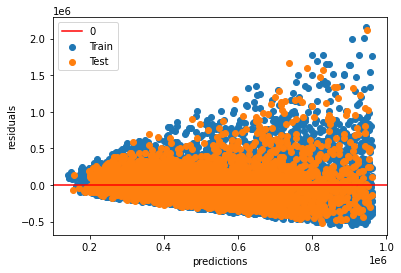

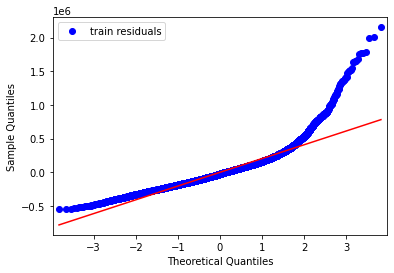

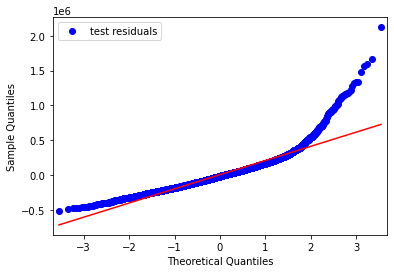

In [46]:
fsm_train_preds = fsm.predict(sm.add_constant(fsm_X_train))
fsm_test_preds = fsm.predict(sm.add_constant(fsm_X_test))

evaluate(y_train, fsm_train_preds, y_test, fsm_test_preds)

As seen from the residuals plot above, there is heteroskedasticity problem, which means that the spread of residuals is different at different levels of the fitted values. In order to overcome heteroskedasticity, we can do variable transformation (i.e. log transformation) of the target column.

In [47]:
# Log transformation of the 'price' column:
logged_fsm_y_train= np.log(y_train)
logged_fsm_y_test = np.log(y_test)
fsm_logged = sm.OLS(logged_fsm_y_train, sm.add_constant(fsm_X_train)).fit()
fsm_logged.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.402
Model:                            OLS   Adj. R-squared:                  0.402
Method:                 Least Squares   F-statistic:                 1.024e+04
Date:                Fri, 08 Oct 2021   Prob (F-statistic):               0.00
Time:                        10:46:14   Log-Likelihood:                -6700.4
No. Observations:               15209   AIC:                         1.340e+04
Df Residuals:                   15207   BIC:                         1.342e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          12.1916      0.009   1405.078      0.000      12.175      12.209
sqft_living     0.0004    4.1e-06    101.201      0.000       0.000       0.000
==============================================================================
Omnibus:                       44.484   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               36.340
Skew:                           0.045   Prob(JB):                     1.28e-08
Kurtosis:                       2.778   Cond. No.                     6.02e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.02e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Train R2: 0.4024
Test R2: 0.3926
*****
Train RMSE: $217,123.32
Test RMSE: $216,210.96
*****
Train MAE: $150,632.73
Test MAE: $149,658.10
*****


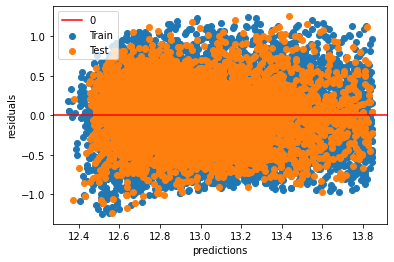

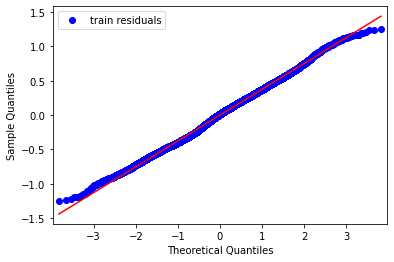

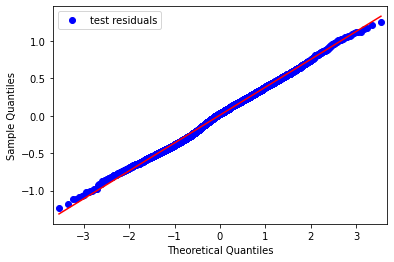

In [48]:
logged_fsm_train_preds = fsm_logged.predict(sm.add_constant(fsm_X_train))
logged_fsm_test_preds = fsm_logged.predict(sm.add_constant(fsm_X_test))

evaluate(logged_fsm_y_train, logged_fsm_train_preds, logged_fsm_y_test, logged_fsm_test_preds, log=True)

Our model R-squared is better than the unlogged price prediction, we also observe that the residuals are spreaded evenly, no cone shape

### Modeling Iterations

#### 1. Selecting New Feature  

Now we will start to use the results of our first model to iterate to our final model by using *next_possible_feature()* function, and calculating the vif-score at each iteration.

In [49]:
# start selecting with the first predictor, and see all other possibilities for our second predictor.
selected_features = ['sqft_living']
next_possible_feature (X_tr=X_train, X_te=X_test, y_tr=logged_fsm_y_train,\
                       y_te=logged_fsm_y_test,current_features=selected_features)

predictor  test r-squared
15             distance        0.607346
9                   lat        0.595636
17  grade_below_average        0.433050
6              yr_built        0.426146
24            view_NONE        0.420480
14             view_YES        0.420480
11        sqft_living15        0.416428
16            house_age        0.415269
19     grade_is_average        0.409082
8               zipcode        0.408398
21       view_EXCELLENT        0.407666
18  grade_above_average        0.406938
10                 long        0.406177
0              bedrooms        0.404065
4            waterfront        0.403489
29       cond_Very Good        0.400593
7          yr_renovated        0.400107
20         view_AVERAGE        0.399685
3                floors        0.397852
25         cond_Average        0.397713
23            view_GOOD        0.397389
26            cond_Fair        0.395277
22            view_FAIR        0.394853
27            cond_Good        0.393626
13   sqft_basement_diff        0.393423
5            sqft_above        0.393423
1             bathrooms        0.393181
12           sqft_lot15        0.393016
2              sqft_lot        0.392662
28            cond_Poor        0.392378

We noticed that 'distance' has the highest r-squared score when combined with 'sqft_living'. Now, we will choose 'distance' for our second predictor, and do the analysis.

#### 2. Modeling With New Feature

Train R2: 0.6056
Test R2: 0.6073
*****
Train RMSE: $177,160.84
Test RMSE: $175,952.72
*****
Train MAE: $119,698.02
Test MAE: $117,651.45
*****


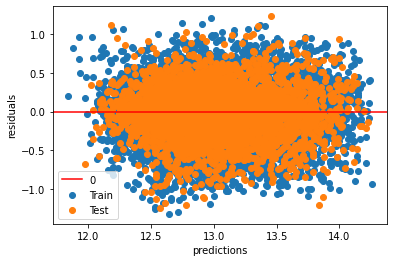

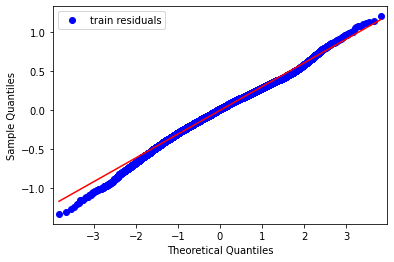

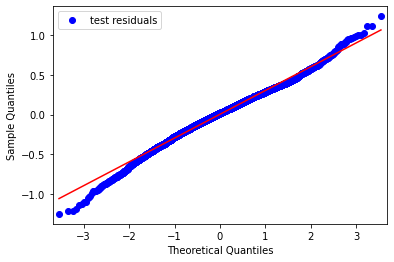

In [50]:
second_predictors = ['sqft_living', 'distance']
second_X_train= X_train[second_predictors]
second_X_test = X_test[second_predictors]
second_model = sm.OLS(logged_fsm_y_train, sm.add_constant(second_X_train)).fit()
second_train_preds = second_model.predict(sm.add_constant(second_X_train))
second_test_preds = second_model.predict(sm.add_constant(second_X_test))
evaluate(logged_fsm_y_train, second_train_preds , logged_fsm_y_test, second_test_preds, log=True)

#### 3. Checking Multicollinearity

In [51]:
# defining an empty dataframe to capture the VIF scores
vif_2 = pd.DataFrame()

# label the scores with their related columns
vif_2["features"] = second_X_train.columns

# For each column,run a variance_inflaction_factor against all other columns to get a VIF Factor score

vif_2["VIF"] = [variance_inflation_factor(second_X_train.values, i) \
                for i in range(len(second_X_train.columns))]

vif_2

features       VIF
0  sqft_living  3.523115
1     distance  3.523115

We used VIF to check for Multicollinearity. Since the values are less than 7, they aren't multicollinear.

From the R-scores getting higher, and vif-scores being less than 7, we decided to keep 'distance' as our second predictor. 

#### 4. Visualizing Model Summary 

In [52]:
second_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.606
Method:                 Least Squares   F-statistic:                 1.167e+04
Date:                Fri, 08 Oct 2021   Prob (F-statistic):               0.00
Time:                        10:46:16   Log-Likelihood:                -3540.7
No. Observations:               15209   AIC:                             7087.
Df Residuals:                   15206   BIC:                             7110.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          12.5210      0.008   1570.695      0.000      12.505      12.537
sqft_living     0.0005   3.36e-06    135.407      0.000       0.000       0.000
distance       -0.0369      0.000    -88.506      0.000      -0.038      -0.036
==============================================================================
Omnibus:                      270.051   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              357.044
Skew:                          -0.236   Prob(JB):                     2.94e-78
Kurtosis:                       3.584   Cond. No.                     6.81e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.81e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### We continued this iteration process for many times, and reached our final model. 

### For further detail of the each iteration process, please see TeamBrass.ipynb jupyter notebook.

### 'Final' Model

Train R2: 0.6524
Test R2: 0.6513
*****
Train RMSE: $161,181.16
Test RMSE: $158,443.31
*****
Train MAE: $111,752.82
Test MAE: $109,847.11
*****


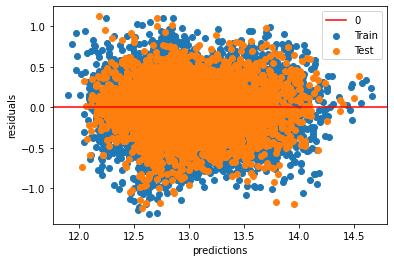

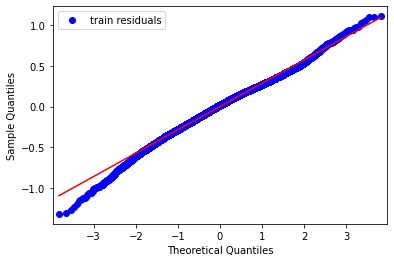

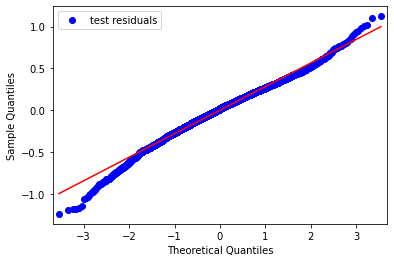

In [53]:
# code here to show your final model
final_predictors = ['sqft_living', 'distance', 'waterfront','grade_below_average', 'view_YES']
final_X_train= X_train[final_predictors]
final_X_test = X_test[final_predictors]
final_model = sm.OLS(logged_fsm_y_train, sm.add_constant(final_X_train)).fit()
final_train_preds = final_model.predict(sm.add_constant(final_X_train))
final_test_preds = final_model.predict(sm.add_constant(final_X_test))
evaluate(logged_fsm_y_train, final_train_preds , logged_fsm_y_test, final_test_preds, log=True)

In [54]:
# defining an empty dataframe to capture the VIF scores
vif_final = pd.DataFrame()

final_X_train = X_train[['sqft_living', 'distance', 'waterfront', 'grade_below_average', 'view_YES']]

# label the scores with their related columns
vif_final["features"] = final_X_train.columns

# For each column,run a variance_inflaction_factor against all other columns to get a VIF Factor score

vif_final["VIF"] = [variance_inflation_factor(final_X_train.values, i) \
                for i in range(len(final_X_train.columns))]

vif_final

features       VIF
0          sqft_living  3.951458
1             distance  4.197206
2           waterfront  1.067818
3  grade_below_average  1.671047
4             view_YES  1.236411

In [55]:
final_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.652
Model:                            OLS   Adj. R-squared:                  0.652
Method:                 Least Squares   F-statistic:                     5708.
Date:                Fri, 08 Oct 2021   Prob (F-statistic):               0.00
Time:                        10:46:17   Log-Likelihood:                -2579.4
No. Observations:               15209   AIC:                             5171.
Df Residuals:                   15203   BIC:                             5216.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  12.7973      0.011   1217.749      0.000      12.777      12.818
sqft_living             0.0004   3.92e-06     91.260      0.000       0.000       0.000
distance               -0.0353      0.000    -88.990      0.000      -0.036      -0.035
waterfront              0.5102      0.033     15.494      0.000       0.446       0.575
grade_below_average    -0.2136      0.006    -37.218      0.000      -0.225      -0.202
view_YES                0.1313      0.009     14.762      0.000       0.114       0.149
==============================================================================
Omnibus:                      274.197   Durbin-Watson:                   1.971
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              350.058
Skew:                          -0.249   Prob(JB):                     9.68e-77
Kurtosis:                       3.551   Cond. No.                     3.00e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large,  3e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### To compare the predictors with each other, we should scale them:

In [56]:
# Instantiate a new scaler
scaler = StandardScaler()
# Learn the pattern from the training data
scaler.fit(final_X_train)
#Apply the pattern to the training and testing data
X_train_scaled = scaler.transform(final_X_train)
X_test_scaled = scaler.transform(final_X_test)
X_train_scaled = pd.DataFrame(X_train_scaled,
                              columns=final_X_train.columns,
                              index=final_X_train.index)

In [57]:
scaled_final_model = sm.OLS(logged_fsm_y_train, sm.add_constant(X_train_scaled)).fit()

In [58]:
scaled_final_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.652
Model:                            OLS   Adj. R-squared:                  0.652
Method:                 Least Squares   F-statistic:                     5708.
Date:                Fri, 08 Oct 2021   Prob (F-statistic):               0.00
Time:                        10:46:17   Log-Likelihood:                -2579.4
No. Observations:               15209   AIC:                             5171.
Df Residuals:                   15203   BIC:                             5216.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  13.0137      0.002   5596.936      0.000      13.009      13.018
sqft_living             0.2662      0.003     91.260      0.000       0.261       0.272
distance               -0.2116      0.002    -88.990      0.000      -0.216      -0.207
waterfront              0.0371      0.002     15.494      0.000       0.032       0.042
grade_below_average    -0.1065      0.003    -37.218      0.000      -0.112      -0.101
view_YES                0.0365      0.002     14.762      0.000       0.032       0.041
==============================================================================
Omnibus:                      274.197   Durbin-Watson:                   1.971
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              350.058
Skew:                          -0.249   Prob(JB):                     9.68e-77
Kurtosis:                       3.551   Cond. No.                         2.05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### 1. The strongest predictor in our model is the sqft_living. It has positive effect on the house price. 
#### 2. The second strongest is the distance, it has negative effect on the house price.
#### 3. Third strongest is the grade_below_average.
#### 4. Fourth is waterfront
#### 5. The last strongest is view_YES. Having a view or not have less effect on the price of the house. 

### Unscaled final model interpretation:

In [59]:
final_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.652
Model:                            OLS   Adj. R-squared:                  0.652
Method:                 Least Squares   F-statistic:                     5708.
Date:                Fri, 08 Oct 2021   Prob (F-statistic):               0.00
Time:                        10:46:17   Log-Likelihood:                -2579.4
No. Observations:               15209   AIC:                             5171.
Df Residuals:                   15203   BIC:                             5216.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  12.7973      0.011   1217.749      0.000      12.777      12.818
sqft_living             0.0004   3.92e-06     91.260      0.000       0.000       0.000
distance               -0.0353      0.000    -88.990      0.000      -0.036      -0.035
waterfront              0.5102      0.033     15.494      0.000       0.446       0.575
grade_below_average    -0.2136      0.006    -37.218      0.000      -0.225      -0.202
view_YES                0.1313      0.009     14.762      0.000       0.114       0.149
==============================================================================
Omnibus:                      274.197   Durbin-Watson:                   1.971
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              350.058
Skew:                          -0.249   Prob(JB):                     9.68e-77
Kurtosis:                       3.551   Cond. No.                     3.00e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large,  3e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### In this model, the target variable, price, is in its log-transformed state, and the predictors are in their original metric. To interpret the amount of change in the original metric of the outcome:
- we first exponentiate the coefficient of the predictor by exp(coef)
- we then calculate the percent change by (exp(coef) - 1)*100


#### Sqft_living coefficient
One 1 sqft increase in the living area, the price increases by 0.04 percent on average.

Every 100 sqft increase in the living area, the price increases by 4 percent on average. 

In [60]:
(np.exp(0.0004)-1)*100 

0.040008001066782484

#### Distance coefficient
One mile increase in distance, the price decreases by 3.5 percent on average.

In [61]:
(np.exp(-0.0356)-1)*100 

-3.4973773217969684

#### Waterfront coefficient
If the house is on the waterfront, the price increases by 66 percent on average.

In [62]:
(np.exp(0.5124)-1)*100

66.9292693691532

#### Grade_below_average coefficent
If the house has below than the average grade, the price decreases by 18 percent on average.

In [63]:
(np.exp(-0.2044)-1)*100

-18.48637485328899

#### View_YES coefficent
If the house has a view, the price increases by 12 percent on average.

In [64]:
(np.exp(0.1220)-1)*100

12.975410178031876

## Conclusions

For a bargain price in King County, the house should: 

- Have less sq ft living area
- Be away from Downtown
- Not be located on waterfront
- Have no view
- Have below average grade

For the next steps, we would like to redo the analysis with recent King County House Dataset, define more variables for prediction, predict price per sq. ft. instead of price, ans use non-linear regression model.
